In [1]:
import numpy as np
import csv
%matplotlib inline
import pandas as pd
from frgpascal.hardware.sampletray import SampleTray, AVAILABLE_VERSIONS as sampletray_versions
from frgpascal.hardware.liquidlabware import TipRack, LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions
from frgpascal.hardware.hotplate import AVAILABLE_VERSIONS as hotplate_versions
from frgpascal.experimentaldesign.helpers import build_sample_list, plot_tray, handle_liquids, samples_to_dataframe, load_sample_trays
from frgpascal.experimentaldesign.tasks import *
from frgpascal.experimentaldesign import characterizationtasks as chtsk
from frgpascal.experimentaldesign.scheduler import Scheduler
from frgpascal.experimentaldesign.protocolwriter import generate_ot2_protocol
from frgpascal.system import build
import mixsol as mx
from random import shuffle

------

# Define Experiment Metadata

In [ ]:
experiment_name = 'Deniz Absorbers for Passivation'
experiment_description = "Deniz Absorbers for Passivation, Round 1"

-----

# Define hardware for this experiment

In [ ]:
print('Available Sample Tray Versions:')
for v in sampletray_versions:
    print(f'\t{v}')

print('\nAvailable Liquid Labwares:')
for v in liquid_labware_versions:
    print(f'\t{v}')

Available Sample Tray Versions:
	storage_v3
	storage_v2
	storage_v1

Available Liquid Labwares:
	frg_12_wellplate_15000ul
	sartorius_safetyspace_tiprack_200ul
	greiner_96_wellplate_360ul
	frg_spincoater_v1
	frg_24_wellplate_4000ul


## Sample Storage Trays
These are the trays used to load samples in/out of the glovebox

In [ ]:
sample_trays = [
    SampleTray(
        name='Tray1',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    ),
    # SampleTray(
    #     name='Tray2',
    #     version='storage_v1',
    #     gantry=None,
    #     gripper=None,
    #     p0=[0,0,0]
    # )
]

## Liquid Labware 

Include _all possible_ liquid storage + pipette tipracks. Later on we will narrow this down to what is required once we know what solutions and volumes we need.

Versions are defined by the same json files used to define custom labware for the Opentrons2 liquid handler. 
New labware can be defined by following https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions

The location of the labware/tiprack on the opentrons deck must be specified as well.


| Deck | Slot | Layout |
| ----------- | ----------- | ----------- |
| 10      | 11       | _Trash_ |
| 7   | 8        | 9 |
|4 | 5 | 6|
|1 | _Spin_ | _Coater_|


For partially consumed tip racks, the `starting_tip` argument can be used to specify the first available tip. Tips before this assumed to be used up. (moves down->right, like A1, B1...H1, A2, B2 etc). If this argument is omitted, we assume to start at tip A1

In [ ]:
tipracks = [
    TipRack(
        version='sartorius_safetyspace_tiprack_200ul', 
        deck_slot=7,
        starting_tip="D7"
    ),
    TipRack(
        version='sartorius_safetyspace_tiprack_200ul', 
        deck_slot=10,
        starting_tip="A2"
    ),
    ]

the `starting_well` argument can be used to similarly specify the first available well on the tray. This is useful for mixing on partially used well plates. Note that the use order of wells differs from tips (moves right->down, like A1, A2,...A12, B1, B2 etc)

In [ ]:
solution_storage = [
    LiquidLabware(
        name='96_Plate1',
        version='greiner_96_wellplate_360ul',
        deck_slot=5,
        starting_well="E1" 
    ),
    LiquidLabware(
        name='4mL_a_SolutionTray',
        version='frg_24_wellplate_4000ul',
        deck_slot=1
    ),
    LiquidLabware(
        name='4mL_b_AntisolventTray',
        version='frg_24_wellplate_4000ul',
        deck_slot=6
    ),
    # LiquidLabware(
    #     name='15mL_Tray1',
    #     version='frg_12_wellplate_15000ul',
    #     deck_slot=8  
    # ),
]

#sort by volume,name
solution_storage.sort(key=lambda labware: labware.name)
solution_storage.sort(key=lambda labware: labware.volume)
print('Priority Fill Order:')
for ss in solution_storage: print(ss)

Priority Fill Order:
<LiquidLabware> 96_Plate1, 0.36 mL volume, 96 wells
<LiquidLabware> 4mL_a_SolutionTray, 4.0 mL volume, 24 wells
<LiquidLabware> 4mL_b_AntisolventTray, 4.0 mL volume, 24 wells


-----

# Define Experimental Mesh

Each of the following cells defines one dimension of the experiment. After defining the individual dimensions, a full sample list will be constructed using a user-selected Design of Expeiment (DOE)

## List of unique substrates that will be loaded to start the experiment.
These are just strings to describe the substrate types.

In [ ]:
input_substrates = [
    '1mm glass'
]

## Solutions to spincast. 

Solutions are defined using `Solution` class instances.

Chemical formula is defined with underscores between each component. If no coefficient is provided, assumes =1. Example:

``` 
SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```
Note that you can use parentheses to simplify the formulae.
``` 
SolutionRecipe(
        solutes='MA_Pb_(I0.8_Br0.2)3',
        solvent='DMF9_DMSO1',
        molarity=1
    )
```

Antisolvents are also defined using `Solution` class instances. Solutes are left empty, and molarity is unused so can be left as 1/whatever number you like.

Example:
``` 
Solution(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    )
```

Solutions that will be interchanged (for example, different absorber solutions for compositional search) should be stored in a list. This list will be used later to permute sample process variables


In [ ]:
absorber_solution = Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1.25,
    )

In [ ]:
methyl_acetate = Solution(
        solvent='MethylAcetate',
        labware='4mL_b_AntisolventTray',
        well='D1',
    )

## Spincoating Recipes


Spincoating recipes are defined using the `Spincoat` object. This takes two arguments: `steps`,a nested list of [speed, acceleration, duration] spin steps, and `drops`, a list of `Drop` objects that capture the details of each solution drop during spincoating. 

```
Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops=[
            Drop(
                solution=target_solutions[0],
                volume=20, # uL
                time=5, # seconds from start of spincoating
                height=2, # mm above substrate to dispense from, optional
                rate=50, # dispense rate (uL/sec), optional
                pre_mix=3, #number of sequential aspirate->dispense cycles to mix solution prior to aspiration, optional
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                rate=150,
                time=30,
                reuse_tip=True #whether to reuse this pipette tip (only uses tips previously used for the same solution.)
            )
        ]
    )
```

often we will be using many solutions with the same spincoating recipe. In these cases, the `solution` argument of a `Drop` object can just be a string. This string can be substituted by a list of solutions at the final step. Example:

```
spincoat_recipes = [
    Spincoat(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        drops = [
            Drop(
                solution='psk_solution', # we will fill any Drop solutions labeled as 'psk_solution' later
                volume=20,
                time=5,
                pre_mix=3,
            ),
            Drop(
                solution=cb_antisolvent,
                volume=50,
                rate=150,
                time=40,
                reuse_tip=True,
            )
        ]
    ),
```

#### Defining spincoating parameters

In [ ]:
spincoat_absorber = Spincoat(
        steps=[
            [3000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=absorber_solution,  #this will be filled later using the list of psk solutions
                volume=20,
                time=-1,
                blow_out=True,
                # pre_mix = (5,50),
            ),
            Drop(
                solution=methyl_acetate,
                volume=50,
                time=22,
                reuse_tip=True,
                touch_tip=False,
                rate=100,
                pre_mix = (3,100),
                slow_travel=True
            )
        ],
    )

## Annealing Conditions
Annealing conditions are defined as a list of `Anneal` class instances. Only two parameters - temperature (C) and duration (s)

Example:
``` 
    Anneal(
        temperature=100, #degrees C
        duration=60*60, #seconds
    ),
```

In [ ]:
anneal_absorber = Anneal(
        temperature=100, #degrees C
        duration=30*60, #seconds
    )

## Characterize Absorber

In [ ]:
char_absorber = Characterize(
    tasks = [
        chtsk.Brightfield(),
        chtsk.PLSpectroscopy(
            exposure_times=[0.1, 5, 20],
            num_scans=1
        ),
        chtsk.TransmissionSpectroscopy(),
        chtsk.Darkfield()
    ]
)

-----

# Design of Experiment

We will input all the values defined above into `build_sample_list` to generate a sample list. Currently only a full-factorial design is implemented. 
The arguments for `build_sample_list` are as follows:
- `input_substrates`: list of substrates (strings) describing the unique starting substrates
- `steps`: worklist of process steps (`Spincoat`, `Anneal`, `Rest`, or `Characterize`) **in desired order of completion**. Each of the list elements can be a single step (if the step does not change across samples), or a list of steps of the same kind (for example, a list of spincoat variations)
- `solution_mesh`: a dictionary used to fill in solution placeholders in `Drop` objects. Keys should match the placeholder strings, and values should be lists of `Solution` objects to put into the `Drop` object.
- `n_repeats`: number of duplicates to run for each unique worklist

arguments are lists defined above, and n_repeats is the number of times to repeat each unique combination of conditions

In [ ]:
samples = build_sample_list(
    # available_trays = sample_trays,
    input_substrates = input_substrates,
    steps = [
        spincoat_absorber, 
        anneal_absorber, 
        Rest(180, immediate=True), 
        char_absorber,
    ],
    n_repeats=36,
)
len(samples)

36

In [ ]:
load_sample_trays(samples, sample_trays)
df = samples_to_dataframe(samples)
df.to_csv(f'SampleDataframe_{experiment_name}.csv')
df.head()

,name,storage_tray,storage_slot,worklist,spincoat0_steps,spincoat0_duration,spincoat0_drop0_solutes,spincoat0_drop0_solvent,spincoat0_drop0_molarity,spincoat0_drop0_time,...,spincoat0_drop1_solvent,spincoat0_drop1_molarity,spincoat0_drop1_time,spincoat0_drop1_height,spincoat0_drop1_rate,anneal0_temperature,anneal0_duration,anneal0_hotplate,rest0_duration,characterize0_characterization_tasks
0,sample0,Tray1,A1,"[{'name': 'spincoat', 'start': nan, 'id': 'spi...","[{'rpm': 3000.0, 'acceleration': 2000.0, 'dura...",99,FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09,DMF3_DMSO1,1.25,-1,...,MethylAcetate,1,22,2,100,100,1800,Hotplate1,180,"[{'name': 'Brightfield', 'station': 'brightfie..."
1,sample1,Tray1,A2,"[{'name': 'spincoat', 'start': nan, 'id': 'spi...","[{'rpm': 3000.0, 'acceleration': 2000.0, 'dura...",99,FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09,DMF3_DMSO1,1.25,-1,...,MethylAcetate,1,22,2,100,100,1800,Hotplate1,180,"[{'name': 'Brightfield', 'station': 'brightfie..."
2,sample2,Tray1,A3,"[{'name': 'spincoat', 'start': nan, 'id': 'spi...","[{'rpm': 3000.0, 'acceleration': 2000.0, 'dura...",99,FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09,DMF3_DMSO1,1.25,-1,...,MethylAcetate,1,22,2,100,100,1800,Hotplate1,180,"[{'name': 'Brightfield', 'station': 'brightfie..."
3,sample3,Tray1,A4,"[{'name': 'spincoat', 'start': nan, 'id': 'spi...","[{'rpm': 3000.0, 'acceleration': 2000.0, 'dura...",99,FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09,DMF3_DMSO1,1.25,-1,...,MethylAcetate,1,22,2,100,100,1800,Hotplate1,180,"[{'name': 'Brightfield', 'station': 'brightfie..."
4,sample4,Tray1,A5,"[{'name': 'spincoat', 'start': nan, 'id': 'spi...","[{'rpm': 3000.0, 'acceleration': 2000.0, 'dura...",99,FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09,DMF3_DMSO1,1.25,-1,...,MethylAcetate,1,22,2,100,100,1800,Hotplate1,180,"[{'name': 'Brightfield', 'station': 'brightfie..."


-----

# Preparing the Solutions

## Define Stock Solutions

These are the solutions that you will be mixing to (hopefully) cover your target solutions. If they don't work, the code will tell you, and you can come back to this point and try again.

In [ ]:
stock_solutions = [
    Solution(
        solutes= 'FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.2)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='A2'
    ),
    Solution(
        solutes= 'FA0.78_Cs0.12_MA0.1_(Pb_(I0.9_Br0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='B2'
    ),
    Solution(
        solutes= 'FA0.78_Cs0.12_MA0.1_(Pb_(I0.9_Cl0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='B1'
    ),
    Solution(
        solutes= 'FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.1_Cl0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='A1'
    ),


    Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.8_Br0.2)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='C2'
    ),
    Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1.25,
        labware='4mL_a_SolutionTray',
        well='D2'
    ),
    Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.9_Cl0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='C1'
    ),
    Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.8_Br0.1_Cl0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1,
        labware='4mL_a_SolutionTray',
        well='D1'
    ),
    methyl_acetate
]

Can we cover target solutions with these stocks? and if so, how much of each stock to mix for each target?

This will throw an error if the stock solutions are not able to cover our experiment

In [ ]:
required_solutions = {}
for s in samples:
    for task in s.worklist:
        if isinstance(task, Spincoat):
            for d in task.drops:
                sol = d.solution
                if sol in required_solutions:
                    required_solutions[sol] += d.volume
                else:
                    required_solutions[sol] = d.volume #50 ul minimum volume per well for successful aspiration

In [ ]:
# for s in fml_solutions:
#     required_solutions[s] += 400

In [ ]:
mixer = mx.Mixer(
    stock_solutions=stock_solutions,
    targets=required_solutions,
)
mixer.solve(
    min_volume=20,
    max_inputs=4,
    tolerance=1e-4,
    strategy='prefer_stock'
)

In [ ]:
mixer.print()

===== Stock Prep =====
1800.00 of MethylAcetate
720.00 of 1.25M FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09 in DMF3_DMSO1


In [ ]:
solution_details, mixing_netlist = handle_liquids(
    samples=samples,
    mixer=mixer,
    solution_storage=solution_storage,
)

#### Plot + save images that map the solution + substrate loading positions

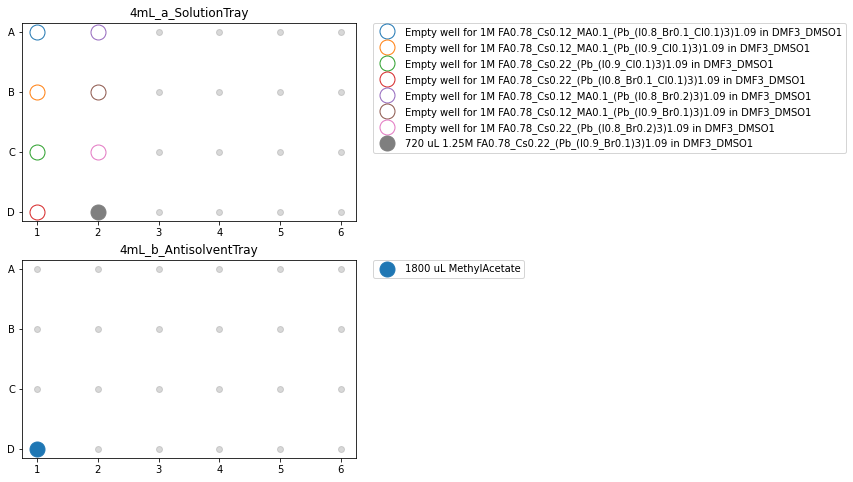

In [ ]:
ll_with_solutions = [
    ll for ll in solution_storage
    if len(ll.contents) > 0
]

fig, ax = plt.subplots(len(ll_with_solutions), 1, figsize=(6,4*len(ll_with_solutions)))
try:
    ax = ax.flat
except:
    ax = [ax]
for ll, ax_ in zip(ll_with_solutions, ax):
    ll.plot(solution_details=solution_details, ax=ax_)
plt.savefig(f"solutionmap_{experiment_name}.jpeg", dpi=150, bbox_inches='tight')

-----

# Build the Experiment Schedule + Save Worklist

New

In [ ]:
system = build()

for s in samples:
    s.protocol = system.generate_protocol(
        worklist = s.worklist,
        name=s.name
    )        

In [ ]:
system.scheduler.solve()

solution status: FEASIBLE


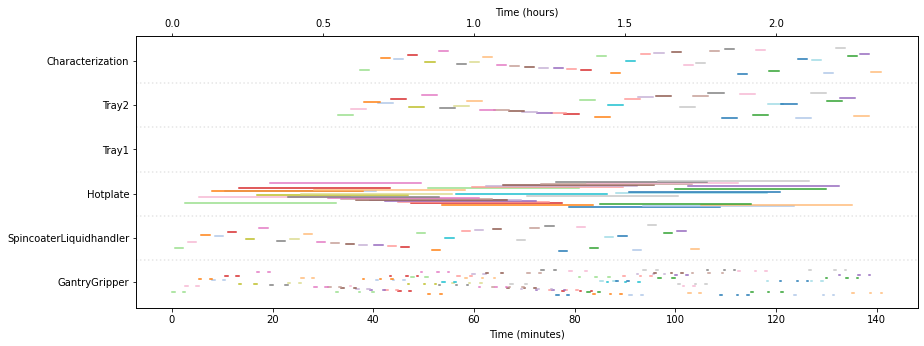

In [ ]:
system.scheduler.plot_solution()

----

# Write final files to disk

## Solution Instructions to csv, tells operator where/how much to put solutions

In [ ]:
with open(f'stocksolutions_{experiment_name}.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    header = [
        'Labware',
        'Well',
        'Volume (uL)',
        'Solutes',
        'Molarity (M)',
        'Solvent',        
    ]
    writer.writerow(header)
    for solution, details in solution_details.items():
        volume = details['initial_volume_required']
        if volume == 0:
            volume = 'Empty Vial'
        line = [
            details['labware'],
            details['well'],
            volume,
            solution.solutes,
            solution.molarity,
            solution.solvent,
        ]
        writer.writerow(line)

Substrate map

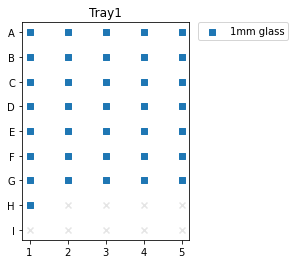

In [ ]:
st_with_samples = [
    st for st in sample_trays
    if len(st.contents) > 0
]

fig, ax = plt.subplots(len(st_with_samples), 1, figsize=(3,4*len(st_with_samples)))
try:
    ax = ax.flat
except:
    ax = [ax]
for ll, ax_ in zip(st_with_samples, ax):
    ll.plot(ax=ax_)
plt.savefig(f"traymap_{experiment_name}.jpeg", dpi=150, bbox_inches='tight')

## Generate protocol for Opentrons liquid handler

In [ ]:
generate_ot2_protocol(
    title=experiment_name,
    mixing_netlist= mixing_netlist,
    labware=solution_storage,
    tipracks=tipracks)
    

OT2 protocol dumped to "./OT2PASCALProtocol_Deniz Absorbers for Passivation.py"


In [ ]:
samples_output = {}
ordered_task_output = []
for sample in samples:
    samples_output[sample.name] = sample.to_dict()
    for task in sample.protocol.worklist:
        taskdict = task.to_dict()
        taskdict['sample'] = sample.name
        ordered_task_output.append(taskdict)

ordered_task_output.sort(key = lambda t: t['start'])
out = {
    'name': experiment_name,
    'description': experiment_description,
    'samples': samples_output,
    'tasks': ordered_task_output,
}

fname = f'maestronetlist_{experiment_name}.json'
with open(fname, 'w') as f:
    json.dump(out, f, indent=4, sort_keys=True)
print(f'Maestro Netlist dumped to "{fname}"')

Maestro Netlist dumped to "maestronetlist_Deniz Absorbers for Passivation.json"


# Powder Weighing Instructions

In [ ]:
stock_solutions

[<Solution> 1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.2)3)1.09 in DMF3_DMSO1,
 <Solution> 1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.9_Br0.1)3)1.09 in DMF3_DMSO1,
 <Solution> 1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.9_Cl0.1)3)1.09 in DMF3_DMSO1,
 <Solution> 1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.1_Cl0.1)3)1.09 in DMF3_DMSO1,
 <Solution> 1M FA0.78_Cs0.22_(Pb_(I0.8_Br0.2)3)1.09 in DMF3_DMSO1,
 <Solution> 1.25M FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09 in DMF3_DMSO1,
 <Solution> 1M FA0.78_Cs0.22_(Pb_(I0.9_Cl0.1)3)1.09 in DMF3_DMSO1,
 <Solution> 1M FA0.78_Cs0.22_(Pb_(I0.8_Br0.1_Cl0.1)3)1.09 in DMF3_DMSO1,
 <Solution> MethylAcetate]

In [ ]:
powders = [
    mx.Powder('Pb_I2'),
    mx.Powder('Pb_Br2'),
    mx.Powder('Pb_Cl2'),
    mx.Powder('Cs_I'),
    mx.Powder(
        formula='MA_I',
        molar_mass=mx.calculate_molar_mass('CH6NI'),
    ),
    mx.Powder(
        formula='FA_I',
        molar_mass=mx.calculate_molar_mass('CH5N2I'),
    )

]
weigher = mx.Weigher(powders=powders)

In [ ]:
stock_details = {k:v for k,v in solution_details.items() if v['is_stock']}

for k,v in stock_details.items():
    print(f"{k}:{v['largest_volume_required']}")

MethylAcetate:1800
1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.9_Cl0.1)3)1.09 in DMF3_DMSO1:0
1M FA0.78_Cs0.22_(Pb_(I0.8_Br0.1_Cl0.1)3)1.09 in DMF3_DMSO1:0
1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.2)3)1.09 in DMF3_DMSO1:0
1.25M FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09 in DMF3_DMSO1:720
1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.9_Br0.1)3)1.09 in DMF3_DMSO1:0
1M FA0.78_Cs0.22_(Pb_(I0.9_Cl0.1)3)1.09 in DMF3_DMSO1:0
1M FA0.78_Cs0.22_(Pb_(I0.8_Br0.2)3)1.09 in DMF3_DMSO1:0
1M FA0.78_Cs0.12_MA0.1_(Pb_(I0.8_Br0.1_Cl0.1)3)1.09 in DMF3_DMSO1:0


In [ ]:
for solution, v in stock_details.items():
    try:
        v['weights'] = weigher.get_weights(solution, volume=1e-3, tolerance=1e-4)
    except:
        v['weights'] = {}

In [ ]:
unique_powders = list(set([p
for v in stock_details.values()
for p in v['weights']]))

In [ ]:
with open('weight_table.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['Solution'] + [f"{p} (mg)" for p in unique_powders])
    for solution, v in stock_details.items():
        line = [solution]
        for p in unique_powders:
            if p in v['weights']:
                line.append(round(v['weights'][p]*1000, 2))
            else:
                line.append('')
        writer.writerow(line)

In [ ]:
for p in powders:
    print(f"{p.formula}:{p.molar_mass}")

Pb_I2:461.00894
Pb_Br2:367.00699999999995
Pb_Cl2:278.1058
Cs_I:259.80992196
MA_I:158.969559
FA_I:171.968321


In [ ]:
for k,v in stock_details.items():
    print(weigher.weights_to_solution(v['weights'], volume=1e-3, solvent='DMF3_DMSO1', molarity=1))

DMF3_DMSO1
1M Cs0.13_I2.933_Cl0.317_MA0.11_FA0.79_Pb1.11 in DMF3_DMSO1
1M Cs0.23_I2.606_Cl0.317_FA0.79_Br0.317_Pb1.11 in DMF3_DMSO1
1M Cs0.13_I2.606_MA0.11_FA0.79_Br0.644_Pb1.11 in DMF3_DMSO1
1M Cs0.2890625_I3.664687_FA0.9890625_Br0.3946875_Pb1.390625 in DMF3_DMSO1
1M Cs0.13_I2.933_MA0.11_FA0.79_Br0.317_Pb1.11 in DMF3_DMSO1
1M Cs0.23125_I2.93175_Cl0.31575_FA0.79125_Pb1.1125 in DMF3_DMSO1
1M Cs0.23125_I2.60475_FA0.79125_Br0.64275_Pb1.1125 in DMF3_DMSO1
1M Cs0.129_I2.607_Cl0.318_MA0.109_FA0.789_Br0.318_Pb1.108 in DMF3_DMSO1
